In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

import pickle

In [2]:
from cpymad.madx import Madx

import sixtracklib as pyst
import pysixtrack

In [3]:
import h5py

In [4]:
from scipy.constants import e, m_p, c, epsilon_0, physical_constants

nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

In [5]:
import sys
sys.path = ["/home/oeftiger/gsi/git/python3/PyHEADTAIL/", 
            "/home/oeftiger/gsi/git/"] + sys.path

In [6]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

from pycuda.driver import memcpy_dtod_async

In [7]:
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.general import pmath as pm
from PyHEADTAIL.particles import generators

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.pypic_factory import create_3dmesh_from_beam, create_mesh
from PyHEADTAIL.spacecharge.pypic_spacecharge import (
    SpaceChargePIC, SpaceChargePIC_Adaptive25D)

from PyHEADTAIL.monitors.monitors import BunchMonitor, ParticleMonitor

from PyHEADTAIL.general.contextmanager import GPU

from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5




/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


PyPIC v2.4.1.2
Info: cusolver_Rf not found. GPU finite difference solver not available.


In [8]:
from PyPIC.GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver_2_5D
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

In [9]:
import PyNAFF as pnf
from tune_diagram import ResonanceLines

In [10]:
n_macroparticles = int(1e6)
n_slices_sc = 3#64

# grid for space charge
n_mesh_nodes = 256
n_mesh_sigma = 12

# intensity = 2.95e10
I = 6e-3 * 0.102/0.016 # in [A]
eps4g_x = 32e-6 # in [m.rad]
eps4g_y = 51e-6 # in [m.rad]
sigma_z = 50
h = 1 # RF harmonic
Qs = 1e-6 #0.005
# bunch_length = 3472.7e-9 # in [s]
# sigma_dp = 1e-15 #2.5e-4/3.

Qx = 4.21
Qy = 3.3

A = 20.18
Q = 7

Ekin_per_nucleon = 11.45e6 # in eV

mismatch_beta = 1.05 # factor for beta function / envelope mismatch
mismatch_disp = 1.0 # factor for dispersion mismatch (only works for finite momentum spread)

###

# from twiss below
circumference = 216.7199935
gamma_tr = 4.893828387

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

f_rev = beta * c / circumference
intensity = I / (h * f_rev) / charge

epsn_x = beta * gamma * eps4g_x / 4
epsn_y = beta * gamma * eps4g_y / 4
# sigma_z = beta * c * bunch_length / 4. # in [m]
## beta_z = 1 #np.abs(eta) * circumference / (2 * np.pi * Qs)
# beta_z = sigma_z / sigma_dp
# epsn_z = sigma_z * sigma_dp * 4 * np.pi * p0 / e # sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)
eta = gamma_tr**-2 - gamma**-2
rf_voltage = 2 * np.pi * p0 * beta * c * Qs**2 / (e * h * np.abs(eta))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)

# <span style='color:red;'>no RF! (also MAD-X rf gaps missing!)</span>

In [11]:
rf_voltage = 0
beta_z = None
Qs = 0

In [12]:
# hor. incoh. space charge tune shift (as per Rahul's paper)
charge * I * circumference / (2*np.pi) / (
    2 * np.pi * epsilon_0 * c * gamma * mass * c**2 * gamma**2 * beta**3 * 
    (epsn_x/(beta*gamma) + np.sqrt(epsn_x * epsn_y * Qx/Qy)/(beta*gamma)))

# 4.6mA should give 0.037 max tune shift

0.39017328592836215

In [13]:
lmbda = intensity * charge / circumference #(np.sqrt(2*np.pi) * sigma_z)   ## I / (beta * c)
Ksc = charge / (gamma**3 * mass * (beta * c)**2) * lmbda / (2*np.pi*epsilon_0)
R = circumference / (2*np.pi)

def dQ_inc(thissize, theothersize, thistune, Ksc=Ksc):
    'incoherent KV tune shift'
    return Ksc * R**2 / (4 * thistune * thissize * (thissize+theothersize))

sig_x = np.sqrt(R / Qx * epsn_x / (beta * gamma))
sig_y = np.sqrt(R / Qy * epsn_y / (beta * gamma))

print ('Gaussian SC tune shifts: dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    2 * dQ_inc(sig_x, sig_y, Qx), 
    2 * dQ_inc(sig_y, sig_x, Qy)))

Gaussian SC tune shifts: dQ_x = 0.195 and dQ_y = 0.175


In [14]:
sig_x, sig_y

(0.008095869535104997, 0.01154403614180247)

In [15]:
def provide_pycuda_array(ptr):
    return gp.GPUArray(n_macroparticles, dtype=np.float64, gpudata=ptr)

# Preparing lattice

In [16]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.09 15:14:50      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [17]:
madx.input('''
rb: sbend,l:= 2.617993878,angle:= 0.2617993878,e1:= 0.1274090354,e2:= 0.1274090354,hgap:= 0.035,type=b1;
iqf=0.311872401;
iqd=-0.496504354;
qs1f: quadrupole,l:= 1.04,k1:= iqf,type=qd1;
qs2d: quadrupole,l:= 1.04,k1:= iqd,type=qd2;
qs3t: quadrupole,l:= 0.4804,k1:= 2*iqf,type=qd3;

sis18: sequence, l = 216.7199935;
rb, at = 1.953996939;
rb, at = 5.541990817;
qs1f, at = 14.20999946;
qs2d, at = 15.84999946;
qs3t, at = 17.31999946;
rb, at = 20.01399639;
rb, at = 23.60199027;
qs1f, at = 32.26999891;
qs2d, at = 33.90999891;
qs3t, at = 35.37999891;
rb, at = 38.07399585;
rb, at = 41.66198973;
qs1f, at = 50.32999837;
qs2d, at = 51.96999837;
qs3t, at = 53.43999837;
rb, at = 56.13399531;
rb, at = 59.72198918;
qs1f, at = 68.38999782;
qs2d, at = 70.02999782;
qs3t, at = 71.49999782;
rb, at = 74.19399476;
rb, at = 77.78198864;
qs1f, at = 86.44999728;
qs2d, at = 88.08999728;
qs3t, at = 89.55999728;
rb, at = 92.25399422;
rb, at = 95.8419881;
qs1f, at = 104.5099967;
qs2d, at = 106.1499967;
qs3t, at = 107.6199967;
rb, at = 110.3139937;
rb, at = 113.9019876;
qs1f, at = 122.5699962;
qs2d, at = 124.2099962;
qs3t, at = 125.6799962;
rb, at = 128.3739931;
rb, at = 131.961987;
qs1f, at = 140.6299956;
qs2d, at = 142.2699956;
qs3t, at = 143.7399956;
rb, at = 146.4339926;
rb, at = 150.0219865;
qs1f, at = 158.6899951;
qs2d, at = 160.3299951;
qs3t, at = 161.7999951;
rb, at = 164.493992;
rb, at = 168.0819859;
qs1f, at = 176.7499946;
qs2d, at = 178.3899946;
qs3t, at = 179.8599946;
rb, at = 182.5539915;
rb, at = 186.1419854;
qs1f, at = 194.809994;
qs2d, at = 196.449994;
qs3t, at = 197.919994;
rb, at = 200.613991;
rb, at = 204.2019848;
qs1f, at = 212.8699935;
qs2d, at = 214.5099935;
qs3t, at = 215.9799935;
endsequence;
''')

True

In [18]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=str(Etot)) # energy in GeV

True

In [19]:
madx.use(sequence="SIS18")

In [20]:
assert madx.command.select(
    flag='MAKETHIN',
    CLASS='QUADRUPOLE',
    SLICE='8',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SBEND',
    slice_='8',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='RBEND',
    slice_='8',
)

In [21]:
madx.command.makethin(
    makedipedge=True,
    style='teapot',
    sequence='SIS18',
)

makethin: style chosen : teapot
makethin: slicing sequence : sis18


True

In [22]:
madx.use(sequence="SIS18")

In [23]:
madx.input('''
    match, sequence=SIS18;
    global, sequence=SIS18, q1={qx}, q2={qy};
    vary, name=iqf, step=0.00001;
    vary, name=iqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=Qx, qy=Qy)
)

START MATCHING

number of sequences: 1
sequence name: sis18
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.79874479e-18





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
iqf                       3.06102e-01  3.11872e-01 -1.00000e+20  1.00000e+20
iqd                      -4.94906e-01 -4.96504e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   1.79874479e-18


True

In [24]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7199935                 -0      0.04175442702        4.893828387 

                q1                dq1            betxmax              dxmax 
              4.21       -26.79592316        16.20846967        18.34019707 

             dxrms             xcomax             xcorms                 q2 
        12.9100195                  0                  0                3.3 

               dq2            betymax              dymax              dyrms 
      -35.89718267        28.07626326                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [25]:
assert circumference == twiss.summary.length # defined above in parameters!
# circumference = twiss.summary.length
assert circumference == twiss['s'][-1]

In [26]:
# madx.input('''
# USE, sequence=FODO;
# ! select, flag=seqedit, class=instrument;
# ! select, flag=seqedit, class=marker;
# SEQEDIT, sequence=FODO;
#     ! remove, element=selected;
#     remove, element=FODO$START;
#     remove, element=FODO$END;
#     flatten;
# ENDEDIT;
# USE, sequence=FODO;
# ''')

# Inject SC markers to compute TWISS functions in these places

In [27]:
n_scnodes = 5*20
l_target = circumference / n_scnodes
l_fuzz = l_target / 2.

l_target

2.1671999349999997

In [28]:
madx.input('sc_placeholder: Marker;')

True

In [29]:
madx.command.seqedit(sequence='SIS18')

True

In [30]:
# remove FODO$start marker, otherwise this space charge node would have 0 length
for i in range(1, len(twiss['name'])):
    el_name = twiss['name'][i]
    s = twiss['s'][i]
    l = twiss['l'][i]
    if not 'drift' in el_name:
        madx.command.install(element='sc_placeholder', at=s)
    else:
        if l < l_target + l_fuzz:
            continue
        l_remaining = l
        s_insert = s - l
        while l_remaining > l_target:
            s_insert += l_target
            madx.command.install(element='sc_placeholder', at=s_insert)
            l_remaining -= l_target

In [31]:
madx.command.flatten()

True

In [32]:
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  625
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [33]:
madx.use(sequence='SIS18')

In [34]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7199935                 -0      0.04175442702        4.893828387 

                q1                dq1            betxmax              dxmax 
              4.21       -26.79592316        16.20846967        18.34019707 

             dxrms             xcomax             xcorms                 q2 
        13.0049834                  0                  0                3.3 

               dq2            betymax              dymax              dyrms 
      -35.89718267        28.07626326                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

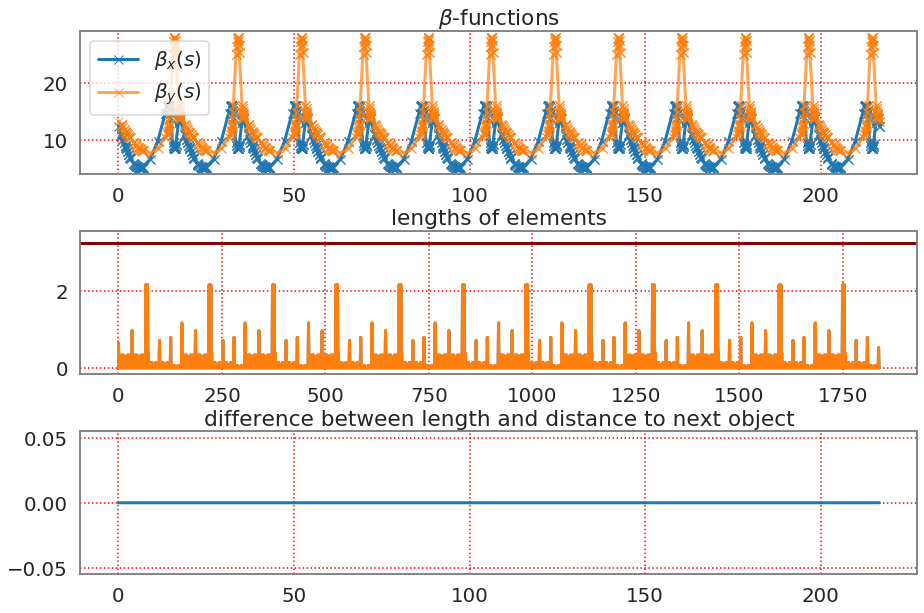

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

plt.sca(ax[0])
plt.title(r'$\beta$-functions')
plt.plot(twiss['s'], twiss['betx'], marker='x', label=r'$\beta_x(s)$')
plt.plot(twiss['s'], twiss['bety'], marker='x', label=r'$\beta_y(s)$', alpha=0.7)
plt.legend()

plt.sca(ax[1])
plt.title('lengths of elements')
plt.plot(np.diff(twiss['s']))
plt.plot(twiss['l'][1:])
plt.axhline(l_target*1.5, color='darkred')
plt.ylim(top=l_target*1.5*1.1)

plt.sca(ax[2])
plt.title('difference between length and distance to next object')
plt.plot(twiss['s'][:-1], np.diff(twiss['s']) - twiss['l'][1:])

plt.subplots_adjust(hspace=0.4)

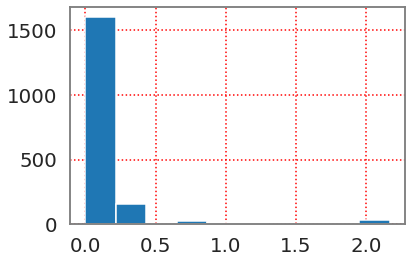

In [36]:
n, _, _ = plt.hist(twiss['l'], bins=10);
# assert n[0] - 1 == np.sum(n[1:])

# Preparing PyHEADTAIL beam

# <span style='color:red;'>no RF $\implies$ coasting monochromatic beam $\implies$ no $D_{x,y}$ contribution!</span>

In [37]:
D_x_0 = 0 * mismatch_disp #twiss['dx'][0] * beta
D_y_0 = 0 * mismatch_disp #twiss['dy'][0] * beta

beta_x_0 = twiss['betx'][0] * mismatch_beta
beta_y_0 = twiss['bety'][0] * mismatch_beta

np.random.seed(0)

pyht_beam = generators.generate_Gaussian6DTwiss(
    n_macroparticles, intensity, charge, mass, circumference, gamma,
    twiss['alfx'][0], twiss['alfy'][0], beta_x_0, beta_y_0,
    1, epsn_x, epsn_y, 1,
    dispersion_x=D_x_0 if D_x_0 else None,
    dispersion_y=D_y_0 if D_y_0 else None,
    limit_n_rms_x=3.4**2, limit_n_rms_y=3.4**2, limit_n_rms_z=3.4**2,
)

In [38]:
# distribution_z_uncut = generators.gaussian2D(
#     sigma_z**2)
# is_accepted = generators.make_is_accepted_within_n_sigma(
#     epsn_rms=sigma_z,
#     limit_n_rms=3.4,
# )
# distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

# z, dp = distribution_z_cut(pyht_beam.macroparticlenumber)
# pyht_beam.z, pyht_beam.dp = z, dp / beta_z

# <span style='color:red;'>no RF $\implies$ coasting monochromatic beam!</span>

In [39]:
pyht_beam.z = np.random.uniform(-circumference/2., circumference/2., pyht_beam.macroparticlenumber)
pyht_beam.dp = np.zeros_like(pyht_beam.z)

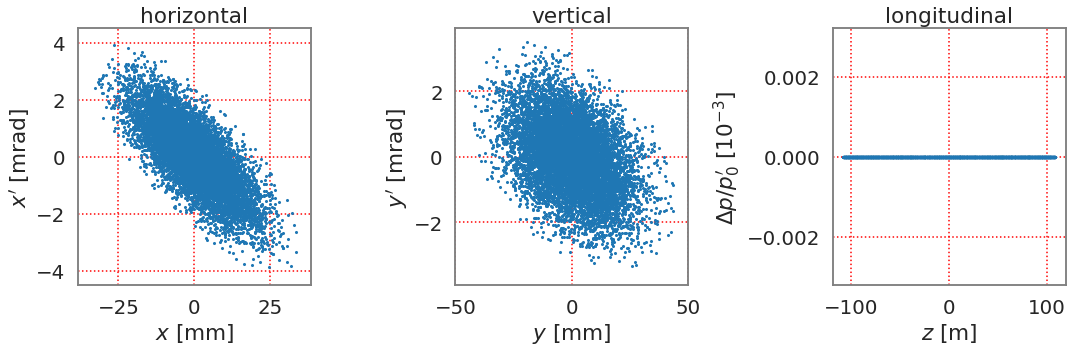

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal')
plt.scatter(pyht_beam.x[::100] * 1e3, pyht_beam.xp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [mrad]")

# plt.axvline(pyht_beam.sigma_x(), color='red')
# plt.axvline(2*pyht_beam.sigma_x(), color='red')
# plt.axvline(3*pyht_beam.sigma_x(), color='red')
# plt.axvline(3.4*pyht_beam.sigma_x(), color='red')

# ep = mpl.patches.Ellipse(
#     (0, 0), 2*pyht_beam.sigma_x() * 1e3, 2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 2*2*pyht_beam.sigma_x() * 1e3, 2*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3*2*pyht_beam.sigma_x() * 1e3, 3*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3.4*2*pyht_beam.sigma_x() * 1e3, 3.4*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='solid')
# plt.gca().add_patch(ep)

plt.sca(ax[1])
plt.title('vertical')
plt.scatter(pyht_beam.y[::100] * 1e3, pyht_beam.yp[::100] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
plt.xlabel('$y$ [mm]')
plt.ylabel("$y'$ [mrad]")

plt.sca(ax[2])
plt.title('longitudinal')
plt.scatter(pyht_beam.z[::100], pyht_beam.dp[::100] * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0'$ [$10^{-3}$]")
plt.tight_layout()

plt.savefig('particle_generation_phasespaces.png', dpi=150, bbox_inches='tight')

# Preparing PySTL for GPU

In [41]:
pyst_beam = pyst.Particles.from_ref(
    num_particles=n_macroparticles, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

In [42]:
pysixtrack_elements, _ = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis18, exact_drift=True, #install_apertures=True
)

In [43]:
# elements = pyst.Elements.from_mad(madx.sequence.SIS18, exact_drift=True)

elements = pyst.Elements.from_line(pysixtrack_elements)

In [44]:
# assert (
#     len(elements.get_elements()) // 2 + 1 == 
#     len(madx.sequence.FODO.elements)
# ), ( 
#     "Did not generate the same number of PySixTrackLib "
#     "lattice elements as there are in the MAD-X lattice! "
#     "This will mess up the computation of SC node lengths..."
# )

$\longrightarrow$ start with a 0-length drift (FODO\\$START marker) and end with a 0-length drift (FODO\\$END marker), otherwise have $(\text{number of multipoles/non-drifts}) + 1$ drifts

In [45]:
# plt.plot(list(map(lambda e: e.length, elements.get_elements())))

In [46]:
idx_mad_sc = [i for i, name in enumerate(madx.sequence.SIS18.element_names()) 
              if 'sc_placeholder' in name]
sc_optics = {
    'beta_x': twiss['betx'][idx_mad_sc],
    'beta_y': twiss['bety'][idx_mad_sc],
    'D_x': twiss['dx'][idx_mad_sc],
    'D_y': twiss['dy'][idx_mad_sc],
    'x': twiss['x'][idx_mad_sc],
    'y': twiss['y'][idx_mad_sc],
    's': twiss['s'][idx_mad_sc]
}

In [47]:
# PySTL contains both drifts and non-drifts in lattice as opposed to MAD-X:
idx_pyst_sc = map(lambda x: 2*x, idx_mad_sc)

In [48]:
idx_pyst_zerodrifts = [
    i for i, el in enumerate(elements.get_elements()) 
    if isinstance(el, pyst.DriftExact) and el.length == 0
]

In [49]:
# # all MAD-X sc_placeholders correspond to a zero-length drift in PySTL
# # (but there are more empty drifts than sc_placeholders)
# assert set(idx_pyst_sc).issubset(set(idx_pyst_zerodrifts))

In [50]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

# Interface to PyHEADTAIL

In [51]:
from pycuda import cumath

In [52]:
class TrackSixTrackLib(Element):
    '''General state.'''
    trackjob = None
    pointers = {}
    context = None
    n_elements = 0

    def __init__(self, trackjob, i_start, i_end, context=context):
        if TrackSixTrackLib.trackjob is None:
            TrackSixTrackLib.trackjob = trackjob

            trackjob.fetch_particle_addresses()
            assert trackjob.last_status_success
            ptr = trackjob.get_particle_addresses() # particleset==0 is default

            TrackSixTrackLib.pointers.update({
                'x': provide_pycuda_array(ptr.contents.x),
                'px': provide_pycuda_array(ptr.contents.px),
                'y': provide_pycuda_array(ptr.contents.y),
                'py': provide_pycuda_array(ptr.contents.py),
                'z': provide_pycuda_array(ptr.contents.zeta),
                'delta': provide_pycuda_array(ptr.contents.delta),
                'rpp': provide_pycuda_array(ptr.contents.rpp),
                'psigma': provide_pycuda_array(ptr.contents.psigma),
                'rvv': provide_pycuda_array(ptr.contents.rvv),
            })
            TrackSixTrackLib.n_elements = len(trackjob.beam_elements_buffer.get_elements())

        self.i_start = i_start
        self.i_end = i_end
        self.is_last_element = (i_end == self.n_elements)

        self.context = context

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        # to be replaced by barrier:
        trackjob.collectParticlesAddresses()

        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        self.memcpy(self.pointers['x'], beam.x)
        self.memcpy(self.pointers['px'], beam.xp)
        self.memcpy(self.pointers['y'], beam.y)
        self.memcpy(self.pointers['py'], beam.yp)
        self.memcpy(self.pointers['z'], beam.z)
        self.memcpy(self.pointers['delta'], beam.dp)
        
        # further longitudinal coordinates of SixTrackLib
        rpp = 1. / (beam.dp + 1)
        self.memcpy(self.pointers['rpp'], rpp)

        restmass = beam.mass * c**2
        restmass_sq = restmass**2
        E0 = np.sqrt((beam.p0 * c)**2 + restmass_sq)
        p = beam.p0 * (1 + beam.dp)
        E = cumath.sqrt((p * c) * (p * c) + restmass_sq)
        psigma =  (E - E0) / (beam.beta * beam.p0 * c)
        self.memcpy(self.pointers['psigma'], psigma)
                    
        gamma = E / restmass
        beta = cumath.sqrt(1 - 1. / (gamma * gamma))
        rvv = beta / beam.beta
        self.memcpy(self.pointers['rvv'], rvv)
        
        self.context.synchronize()

    @staticmethod
    def memcpy(dest, src):
        '''device memory copy with pycuda from src GPUArray to dest GPUArray.'''
#         dest[:] = src
#         memcpy_atoa(dest, 0, src, 0, len(src))
        memcpy_dtod_async(dest.gpudata, src.gpudata, src.nbytes)

    def stlib_to_pyht(self, beam):
        beam.x = self.pointers['x']
        beam.xp = self.pointers['px']
        beam.y = self.pointers['y']
        beam.yp = self.pointers['py']
        beam.z = self.pointers['z']
        beam.dp = self.pointers['delta']

# Prepare PyHEADTAIL style one-turn map

In [53]:
def rms_beam_size(beta_optics, epsn, disp_optics, 
                  sigma_dp=pyht_beam.sigma_dp(), beta=beta, gamma=gamma):
    return np.sqrt(beta_optics * epsn / (beta * gamma) + (disp_optics * sigma_dp)**2)

In [54]:
sig_x = rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).max()
sig_y = rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).max()

In [55]:
print ('The smallest horizontal beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_x - rms_beam_size(sc_optics['beta_x'], epsn_x, sc_optics['D_x']).min()) / sig_x * 100))

print ('The smallest vertical beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sig_y - rms_beam_size(sc_optics['beta_y'], epsn_y, sc_optics['D_y']).min()) / sig_y * 100))

The smallest horizontal beam size is 43.02% smaller than the largest beam size.
The smallest vertical beam size is 47.34% smaller than the largest beam size.


# <span style='color:red;'>coasting beam $\implies$ slicing region!</span>

In [56]:
slicer_sc = UniformBinSlicer(n_slices_sc, #n_sigma_z=4) #
                             z_cuts=(-circumference * 1.501, circumference * 1.501))

In [57]:
slices = pyht_beam.get_slices(slicer_sc)
assert not any(slices.particles_outside_cuts)

In [58]:
# mesh_3d = create_3dmesh_from_beam(pyht_beam, [n_mesh_nodes]*2, [n_mesh_sigma]*2, 
#                                   slices=pyht_beam.get_slices(slicer_sc))

mesh_origin = [-n_mesh_sigma * sig_x, 
               -n_mesh_sigma * sig_y]
mesh_distances = [2 * n_mesh_sigma * sig_x / n_mesh_nodes, 
                  2 * n_mesh_sigma * sig_y / n_mesh_nodes]
mesh_3d = create_mesh(mesh_origin, mesh_distances, [n_mesh_nodes]*2, slices=slices)

In [59]:
poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
# poissonsolver = GPUFFTPoissonSolver(mesh_3d, context=context)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)

In [60]:
circumference

216.7199935

In [61]:
sum(el.length for el in elements.get_elements() if isinstance(el, pyst.DriftExact))

216.7199935

# <span style='color:red;'>vvv Removing longitudinal drift from `SixTrackLib` vvv</span>

In [62]:
class TrackSixTrackLib_NoLongDrift(TrackSixTrackLib):
    '''Simply undoes the longitudinal drift.'''
    def track(self, beam):
        z0 = beam.z.copy()
        super(TrackSixTrackLib_NoLongDrift, self).track(beam)
        beam.z = z0

Assemble the one turn map with interleaved `PySixTrackLib` single-particle tracking and `PyHEADTAIL` space charge nodes:

In [63]:
one_turn_map = []

relevant_elements = elements.get_elements()

if isinstance(elements.get_elements()[-1], pyst.BeamMonitor):
    relevant_elements = relevant_elements[:-1]

i_last = 0
length_covered = 0
for i_curr, el in enumerate(relevant_elements):
    if not isinstance(el, pyst.DriftExact):
        continue
    length_covered += el.length

    #i_curr == 0 or 
    if el.length != 0 : # only inject SC node at markers (for SC)
        continue

#     pyst_node = TrackSixTrackLib(trackjob, i_last, i_curr + 1, context=context)
    pyst_node = TrackSixTrackLib_NoLongDrift(trackjob, i_last, i_curr + 1, context=context)
    one_turn_map.append(pyst_node)

    sc_node = SpaceChargePIC(length_covered, pypic_algorithm)
    one_turn_map.append(sc_node)

    i_last = i_curr
    length_covered = 0

assert pyst_node.i_end == len(relevant_elements)
assert el._offset == relevant_elements[-1]._offset
assert isinstance(el, pyst.DriftExact)
assert el.length == 0

pyst_node.is_last_element = True

In [64]:
len(one_turn_map)

1374

# Tracking space charge and full optics:

In [65]:
alpha_x = twiss['alfx'][0]
beta_x = twiss['betx'][0]
alpha_y = twiss['alfy'][0]
beta_y = twiss['bety'][0]

In [66]:
def get_action(u, up, dp=None, alpha_twiss=0, beta_twiss=1, disp=0):
    if disp and dp.any():
        u = u - disp * dp
    gamma_twiss = (1 + alpha_twiss**2) / beta_twiss
    J = 0.5 * (gamma_twiss * u**2 + 2*alpha_twiss * u * up + beta_twiss * up**2)
    return J

In [67]:
import PyHEADTAIL.gpu.thrust_interface as thrust

def gpu_sort(ary):
    sortd = ary.copy() # thrust sorts in place
    thrust.sort_double(sortd)
    return sortd

pm._CPU_numpy_func_dict['sort'] = np.sort
pm._GPU_func_dict['sort'] = gpu_sort

pm.update_active_dict(pm._CPU_numpy_func_dict)

In [68]:
J_quantiles = np.arange(0, 1, 0.05) + 0.05

J_quantiles_ids = list((J_quantiles * n_macroparticles).astype(int) - 1)

def get_J_xy_quantiles(
        pyht_beam, J_quantiles_ids=J_quantiles_ids, 
        alpha_x=alpha_x, alpha_y=alpha_y, 
        beta_x=beta_x, beta_y=beta_y):    
    J_x = get_action(pyht_beam.x, pyht_beam.xp, alpha_twiss=alpha_x, beta_twiss=beta_x)
    J_x_quantiles = pm.ensure_CPU(pm.sort(J_x))[J_quantiles_ids]

    J_y = get_action(pyht_beam.y, pyht_beam.yp, alpha_twiss=alpha_y, beta_twiss=beta_y)
    J_y_quantiles = pm.ensure_CPU(pm.sort(J_y))[J_quantiles_ids]
    return J_x_quantiles, J_y_quantiles

Small offset for finite centroid motion:

In [69]:
pyht_beam.x += 1e-3 - pyht_beam.mean_x()
pyht_beam.y += 1e-3 - pyht_beam.mean_y()

Let's track:

In [70]:
n_turns = 1024 #128 - 1 #5000 #
n_stored_particles = 1000

bunchmon = BunchMonitor('bunchmonitor', n_turns + 1, write_buffer_every=1)
partmon = ParticleMonitor('particlemonitor', stride=n_macroparticles // n_stored_particles)

# emittance quantiles evolution
rec_epsn_q_x = np.empty((n_turns + 1, len(J_quantiles)), dtype=float)
rec_epsn_q_y = np.empty_like(rec_epsn_q_x)

J_x, J_y = get_J_xy_quantiles(pyht_beam)
rec_epsn_q_x[0, :] = beta * gamma * J_x
rec_epsn_q_y[0, :] = beta * gamma * J_y

with GPU(pyht_beam):
    bunchmon.dump(pyht_beam)
    partmon.dump(pyht_beam)

    for i in range(1, n_turns+1):
        for m in one_turn_map:
            m.track(pyht_beam)

        bunchmon.dump(pyht_beam)
        
        pyht_beam.sort_for('id')
        partmon.dump(pyht_beam)

        J_x, J_y = get_J_xy_quantiles(pyht_beam)
        rec_epsn_q_x[i, :] = beta * gamma * J_x
        rec_epsn_q_y[i, :] = beta * gamma * J_y
        
        sys.stdout.write('\rTurn {}/{}'.format(i, n_turns))

Turn 1024/1024

In [71]:
pickle.dump(pyht_beam, open('SIS_18_beam.p', 'wb'))

In [72]:
np.save('results_epsn_quantiles_x', rec_epsn_q_x)
np.save('results_epsn_quantiles_y', rec_epsn_q_y)

In [73]:
with h5py.File('particlemonitor.h5part', 'r') as fp:
    n_steps = len([st for st in fp.keys() if 'Step' in st])
    n_stored_particles = len(fp['Step#0']['x'])
    
    rec_inc_x = np.empty((n_steps, n_stored_particles), dtype=np.float32)
    rec_inc_xp = np.empty_like(rec_inc_x)
    rec_inc_y = np.empty_like(rec_inc_x)
    rec_inc_yp = np.empty_like(rec_inc_x)
    rec_inc_z = np.empty_like(rec_inc_x)
    rec_inc_dp = np.empty_like(rec_inc_x)
    
    for i in range(n_steps):
        rec_inc_x[i, :] = fp['Step#{}'.format(i)]['x']
        rec_inc_xp[i, :] = fp['Step#{}'.format(i)]['xp']
        rec_inc_y[i, :] = fp['Step#{}'.format(i)]['y']
        rec_inc_yp[i, :] = fp['Step#{}'.format(i)]['yp']
        rec_inc_z[i, :] = fp['Step#{}'.format(i)]['z']
        rec_inc_dp[i, :] = fp['Step#{}'.format(i)]['dp']

In [74]:
with h5py.File('bunchmonitor.h5', 'r') as fb:
    rec_mean_x = np.array(fb['Bunch']['mean_x'])
    rec_mean_y = np.array(fb['Bunch']['mean_y'])
    rec_std_x = np.array(fb['Bunch']['sigma_x'])
    rec_std_y = np.array(fb['Bunch']['sigma_y'])
    rec_epsn_x = np.array(fb['Bunch']['epsn_x'])
    rec_epsn_y = np.array(fb['Bunch']['epsn_y'])

In [75]:
rec_epsn100_x = rec_epsn_q_x[:, -1]
rec_epsn100_y = rec_epsn_q_y[:, -1]

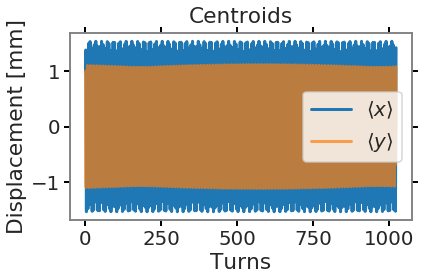

In [76]:
plt.plot(rec_mean_x * 1e3, label=r'$\langle x \rangle$')
plt.plot(rec_mean_y * 1e3, label=r'$\langle y \rangle$', alpha=0.7)
plt.legend()
plt.xlabel('Turns')
plt.ylabel('Displacement [mm]')
plt.title('Centroids', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('SIS18_with_PIC_SC_centroids.png', dpi=150, bbox_inches='tight')

Since we are using a self-consistent particle-in-cell model for space charge, the centroid must not show any incoherent frequency content, which is indeed the case (the orange lines are the TWISS tune, i.e. the bare machine tune):

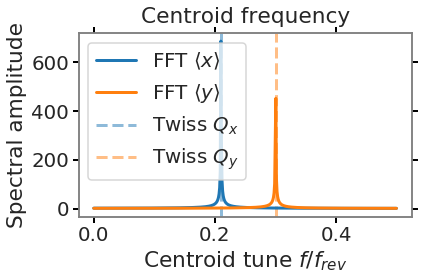

In [77]:
current_palette = sns.color_palette()
plt.plot(np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_mean_x)) * 1e3, label=r'FFT $\langle x \rangle$')
plt.plot(np.fft.rfftfreq(n_turns+1), np.abs(np.fft.rfft(rec_mean_y)) * 1e3, label=r'FFT $\langle y \rangle$')
plt.axvline(twiss.summary['q1']%1, color=current_palette[0], ls='--', alpha=0.5, zorder=-1, label='Twiss $Q_x$')
plt.axvline(twiss.summary['q2']%1, color=current_palette[1], ls='--', alpha=0.5, zorder=-1, label='Twiss $Q_y$')
# plt.xlim(right=1.1)
plt.legend()
plt.xlabel('Centroid tune $f/f_{rev}$')
plt.ylabel('Spectral amplitude')
plt.title('Centroid frequency', y=1.02)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('SIS18_with_PIC_SC_centroidspectra.png', dpi=150, bbox_inches='tight')

Emittances did not change over the simulation:

In [78]:
pyht_beam.epsn_x() / epsn_x

0.9837563559651291

In [79]:
pyht_beam.epsn_y() / epsn_y

0.9825176702928984

All particles still alive? (i.e. none eaten by `PySixTrackLib`'s global aperture):

In [80]:
all(pyst_beam.state)

True

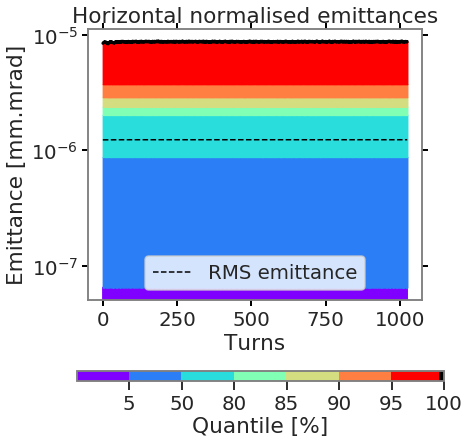

In [81]:
J_chosen_ids = [0, 9, 15, 16, 17, 18, 19]

NUM_COLORS = len(J_chosen_ids)
cm = plt.get_cmap('rainbow')

i_cgen = [cm(1.*i/float(NUM_COLORS - 1)) for i in range(NUM_COLORS)]

plt.figure(figsize=(6, 5))

last_J_idx = J_chosen_ids[0]
plt.fill_between(np.arange(len(rec_epsn_q_x)),
                 0,
                 rec_epsn_q_x[:, last_J_idx],
                 color=i_cgen[0])

for J_idx, col in zip(J_chosen_ids[1:], i_cgen[1:]):
    plt.fill_between(np.arange(len(rec_epsn_q_x)),
                     rec_epsn_q_x[:, last_J_idx],
                     rec_epsn_q_x[:, J_idx],
                     color=col)
    last_J_idx = J_idx

plt.plot(rec_epsn_q_x[:, last_J_idx], color='black')

plt.plot(rec_epsn_x, color='black', ls='--', lw=1.5, label='RMS emittance')
plt.legend(loc=8)

plt.yscale('log')
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='none')

plt.xlabel('Turns')
plt.ylabel('Emittance [mm.mrad]')
plt.title('Horizontal normalised emittances')

cmap = cm.from_list('Custom cmap', i_cgen, NUM_COLORS)
bounds = np.concatenate(([0], J_quantiles[J_chosen_ids]*100))
norm = mpl.colors.BoundaryNorm(bounds, NUM_COLORS)

ax2 = plt.gcf().add_axes([0.1, -0.1, 0.85, 0.03])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, #spacing='proportional', 
                               boundaries=bounds,
                               ticks=J_quantiles[J_chosen_ids]*100, orientation='horizontal')
cb.set_label('Quantile [%]')
ax2.axvline(1, color='black', lw=10)
plt.savefig('SIS18_with_PIC_SC_epsn_quantiles_x.png', dpi=150, bbox_inches='tight')

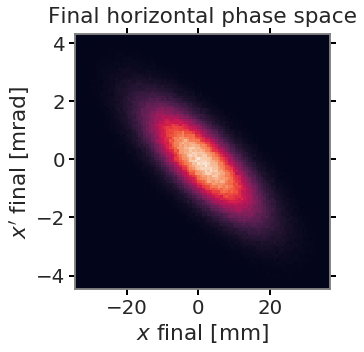

In [82]:
plt.figure(figsize=(6, 5))
plt.hist2d(pyht_beam.x*1e3, pyht_beam.xp*1e3, bins=100)
plt.xlabel('$x$ final [mm]')
plt.ylabel('$x\'$ final [mrad]')
plt.title('Final horizontal phase space', y=1.02)
plt.gca().set_aspect(np.diff(plt.xlim()) / np.diff(plt.ylim()))
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('SIS18_with_PIC_SC_bunch.png', dpi=150, bbox_inches='tight')

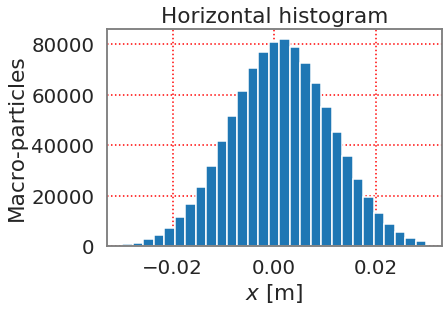

In [83]:
plt.hist(pyht_beam.x, bins=np.linspace(-pyht_beam.sigma_x()*3, pyht_beam.sigma_x()*3, 30));
plt.xlabel('$x$ [m]')
plt.ylabel('Macro-particles')
plt.title('Horizontal histogram');

In [84]:
assert all([all(pyht_beam.x), all(pyht_beam.xp), all(pyht_beam.y), all(pyht_beam.yp), all(pyht_beam.z)])

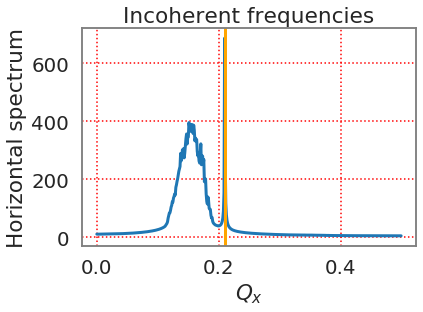

In [85]:
plt.plot(np.fft.rfftfreq(n_turns+1), np.sum(np.abs(np.fft.rfft(rec_inc_x, axis=0)), axis=1))
plt.axvline(twiss.summary['q1']%1, color='orange')
plt.xlabel('$Q_x$')
plt.ylabel('Horizontal spectrum')
plt.title('Incoherent frequencies');

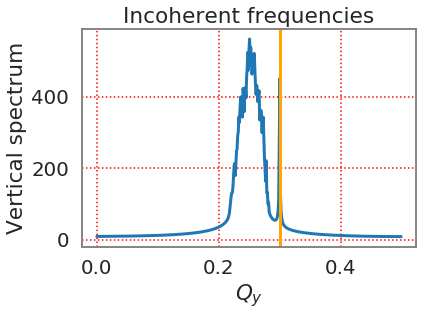

In [86]:
plt.plot(np.fft.rfftfreq(n_turns+1), np.sum(np.abs(np.fft.rfft(rec_inc_y, axis=0)), axis=1))
plt.axvline(twiss.summary['q2']%1, color='orange')
plt.xlabel('$Q_y$')
plt.ylabel('Vertical spectrum')
plt.title('Incoherent frequencies');

# Tune footprint

In [87]:
def get_tune(signal_128_turns):
    return pnf.naff(signal_128_turns, 128, 1, 0 , False, window=1)[0,1]

In [88]:
qx_i = np.array([get_tune(i) for i in rec_inc_x.T])
qy_i = np.array([get_tune(i) for i in rec_inc_y.T])

In [89]:
Qx = twiss.summary['q1']
Qy = twiss.summary['q2']

In [90]:
Qx, Qy

(4.21, 3.3)

0.09648002350521508 0.09618530636252233


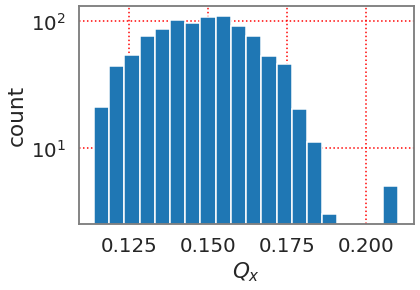

In [91]:
_, bins, _ = plt.hist(qx_i, bins=20);
plt.yscale('log')
plt.xlabel('$Q_x$')
plt.ylabel('count')
print (bins[-1] - bins[0], (Qx%1) - min(bins))

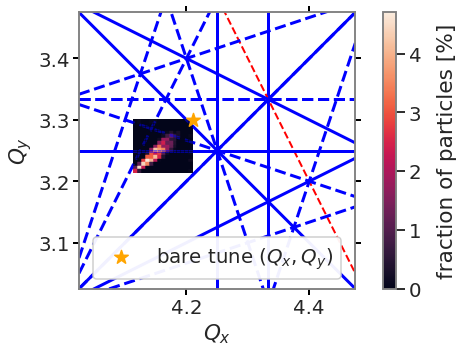

In [92]:
fig = plt.figure(figsize=(8,5)) 

# extent_x = (np.floor(Qx) + 0.475, np.ceil(Qx) + 0.025 - 0.25)
# extent_y = (np.floor(Qy) + 0.475, np.ceil(Qy) + 0.025 - 0.25)
extent_x = (np.floor(Qx) + 0.025, np.floor(Qx) + 0.475)
extent_y = (np.floor(Qy) + 0.025, np.floor(Qy) + 0.475)

resonances = ResonanceLines(extent_x, 
                            extent_y,
                            range(1, 4+1), 12)
resonances.plot_resonance(fig)
plt.gca().set_aspect('equal')

# inc_tunes_x = np.ceil(Qx) - np.abs(qx_i)
# inc_tunes_y = np.ceil(Qy) - np.abs(qy_i)
inc_tunes_x = np.floor(Qx) + np.abs(qx_i)
inc_tunes_y = np.floor(Qy) + np.abs(qy_i)

plt.hist2d(inc_tunes_x, inc_tunes_y, bins=15,
           zorder=12, alpha=0.5, weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100)
plt.hist2d(inc_tunes_x, inc_tunes_y, bins=15, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100)
cbar = plt.colorbar()
cbar.set_label('fraction of particles [%]', labelpad=15)

plt.xlim(extent_x)
plt.ylim(extent_y)

plt.scatter(Qx, Qy, color='orange', marker='*', linestyle='None', s=200, zorder=13, label=r"bare tune $(Q_x,Q_y)$")
plt.legend(loc=8, framealpha=0.95)

plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)

plt.tight_layout()
plt.savefig('SIS18_with_PIC_SC_tunespread.png', dpi=150, bbox_inches='tight')

# Quadrupolar spectrum

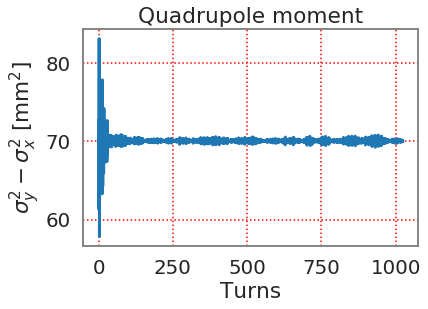

In [93]:
plt.plot(1e6*(rec_std_y**2 - rec_std_x**2))
plt.xlabel('Turns')
plt.ylabel(r'$\sigma_y^2 - \sigma_x^2$ [mm${}^2$]')
plt.title('Quadrupole moment');

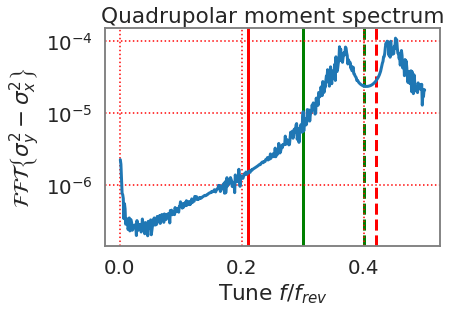

In [94]:
plt.plot(np.fft.rfftfreq(len(rec_std_x))[1:], np.abs(np.fft.rfft((rec_std_y**2 - rec_std_x**2)))[1:])
plt.axvline(Qx%1, color='red', zorder=0)
plt.axvline(Qy%1, color='green', zorder=0)
plt.axvline(2*Qx%1, color='red', zorder=0, ls='--')
plt.axvline(1-2*Qy%1, color='green', zorder=0, ls='--')
plt.yscale('log')
plt.title('Quadrupolar moment spectrum')
plt.ylabel(r'$\mathcal{FFT}\left\{\sigma_y^2 - \sigma_x^2\right\}$')
plt.xlabel(r'Tune $f/f_{rev}$');

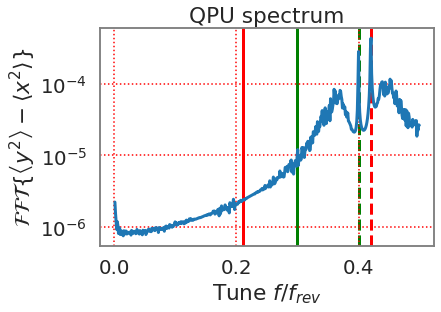

In [95]:
plt.plot(np.fft.rfftfreq(len(rec_std_x))[1:], np.abs(np.fft.rfft(
    ((rec_mean_y**2 - rec_mean_x**2) + rec_std_y**2 - rec_std_x**2)
))[1:])
plt.axvline(Qx%1, color='red', zorder=0)
plt.axvline(Qy%1, color='green', zorder=0)
plt.axvline(2*Qx%1, color='red', zorder=0, ls='--')
plt.axvline(1-2*Qy%1, color='green', zorder=0, ls='--')
plt.yscale('log')
plt.title('QPU spectrum')
plt.ylabel(r'$\mathcal{FFT}\{\left\langle y^2\right\rangle - \left\langle x^2\right\rangle\}$')
plt.xlabel(r'Tune $f/f_{rev}$');